# MVP Notebook — SARIMA (monthly) → Mean–Variance Optimization (Sharpe with rf)
This notebook implements an end-to-end MVP pipeline:
1) Download prices from Yahoo Finance (`yfinance`)
2) Convert to monthly returns
3) Fit SARIMA/SARIMAX *per ticker* to forecast 12 monthly returns (≈1-year horizon)
4) Build robust expected returns: `mu_final = (1-α)*mu_hist + α*mu_arima`
5) Estimate annual covariance Σ from monthly returns
6) Optimize weights with constraints (long-only, min/max weights, max volatility) maximizing Sharpe with rf

> Notes: Educational MVP, not financial advice. For production: shrinkage covariance, turnover penalties, costs, and backtesting.


In [48]:
!pip install jinja2

In [49]:
# If needed:
# !pip install yfinance statsmodels scipy pandas numpy

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import yfinance as yf

from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.optimize import minimize

from IPython.display import display

import matplotlib.pyplot as plt
import matplotlib.dates as mdates


## 1) Parameters de entrada

In [ ]:
# --- Portfolio input (define investments; weights will be computed automatically) ---
portfolio = {
    "AAPL": 1500.0,   # Apple Inc.
    "MSFT": 2000.0,   # Microsoft Corporation
    "GOOGL": 1800.0,  # Alphabet Inc.
    "AMZN": 3000.0,   # Amazon.com, Inc.
    "INTC": 3000.0    # Intel Corporation
}

# Optional benchmark ticker (for comparison, not required)
benchmark = "SPY"  # set to None if you don't want it

# --- Derived tickers + current weights (auto) ---
tickers = list(portfolio.keys())

total_investment = float(sum(portfolio.values()))
current_weights = pd.Series({t: float(v) / total_investment for t, v in portfolio.items()}).sort_index()
# Display portfolio summary
portfolio_summary = pd.DataFrame({
    "investment": pd.Series(portfolio),
    "weight": current_weights
}).sort_values("investment", ascending=False)

# --- Dates ---
start_date = "2016-01-01"
end_date   = "2025-12-31"

# --- Forecast horizon ---
H = 12  # 12 months forecast (≈ 1 year)

# --- Blending expected returns ---
alpha = 0.2  # 0.1–0.3 recommended

# --- Risk-free & constraints ---
risk_free_rate = 0.04   # annual
max_volatility = 0.225  # annual
min_weight = 0.01
max_weight = 0.25

# --- SARIMA config (simple & stable) ---
sarima_order = (1, 0, 1)
seasonal_order = (0, 0, 1, 12)

# Notes:
# - If a ticker fails to fit, we fall back to historical mean.
# - Constraints must be feasible: len(tickers)*min_weight <= 1.


## 2) Download prices (Yahoo Finance) and build monthly returns

In [51]:
def download_prices_yf(tickers, start_date, end_date):
    data = yf.download(
        tickers,
        start=start_date,
        end=end_date,
        auto_adjust=True,
        progress=False
    )["Close"]
    if isinstance(data, pd.Series):
        data = data.to_frame()
    return data

symbols = tickers.copy()
if benchmark is not None and benchmark not in symbols:
    symbols.append(benchmark)

prices_d = download_prices_yf(symbols, start_date, end_date)

# Basic cleaning: drop tickers with too many missing values (portfolio tickers only)
min_coverage = 0.90
coverage = 1 - prices_d[tickers].isna().mean()
keep = coverage[coverage >= min_coverage].index.tolist()
dropped = sorted(set(tickers) - set(keep))

# Keep: portfolio tickers that passed + benchmark (if available)
cols_to_keep = keep + ([benchmark] if benchmark is not None and benchmark in prices_d.columns else [])
prices_d = prices_d[cols_to_keep].dropna(how="all")

print("Kept portfolio tickers:", keep)
if dropped:
    print("Dropped (insufficient data coverage):", dropped)
if benchmark is not None:
    print("Benchmark:", benchmark if benchmark in prices_d.columns else f"{benchmark} (not available)")

# Convert to monthly end-of-month prices
prices_m = prices_d.resample("ME").last().dropna(how="all")

# Monthly returns
ret_m = prices_m.pct_change().dropna(how="all")

# Display as percentages
ret_m.tail(10).style.format("{:.2%}")

Kept portfolio tickers: ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'INTC']
Benchmark: SPY


Ticker,AAPL,MSFT,GOOGL,AMZN,INTC,SPY
Date,,,,,,
2025-03-31 00:00:00,-8.15%,-5.44%,-9.08%,-10.37%,-4.30%,-5.57%
2025-04-30 00:00:00,-4.34%,5.29%,2.69%,-3.07%,-11.49%,-0.87%
2025-05-31 00:00:00,-5.36%,16.68%,8.15%,11.16%,-2.74%,6.28%
2025-06-30 00:00:00,2.15%,8.05%,2.74%,7.01%,14.58%,5.14%
2025-07-31 00:00:00,1.17%,7.26%,8.89%,6.71%,-11.61%,2.30%
2025-08-31 00:00:00,11.96%,-4.87%,10.95%,-2.18%,22.98%,2.05%
2025-09-30 00:00:00,9.69%,2.22%,14.28%,-4.12%,37.78%,3.56%
2025-10-31 00:00:00,6.18%,-0.03%,15.67%,11.23%,19.20%,2.38%
2025-11-30 00:00:00,3.24%,-4.80%,13.87%,-4.50%,1.43%,0.19%


## 3) Fit SARIMA per ticker and forecast 12 monthly returns

In [52]:
def forecast_returns_sarima(series_m, H, order=(1,0,1), seasonal_order=(0,0,1,12)):
    """Forecast H monthly returns using SARIMA/SARIMAX on a single return series."""
    y = series_m.dropna()
    if len(y) < 36:
        raise ValueError("Not enough monthly data points (need ~36+).")

    model = SARIMAX(
        y,
        order=order,
        seasonal_order=seasonal_order,
        trend="c",  # allow a constant mean (for returns)
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    res = model.fit(disp=False)
    fc = res.forecast(steps=H)
    return fc

mu_arima = {}
forecast_paths = {}

for t in [c for c in ret_m.columns if c in tickers]:
    try:
        fc = forecast_returns_sarima(ret_m[t], H, sarima_order, seasonal_order)
        forecast_paths[t] = fc
        mu_arima[t] = float(np.prod(1 + fc.values) - 1)  # 12-step monthly forecast -> 1y
    except Exception as e:
        # Fallback: historical mean monthly return compounded for H months
        m = float(ret_m[t].mean())
        mu_arima[t] = float((1 + m)**H - 1)
        forecast_paths[t] = pd.Series([m]*H, index=pd.date_range(ret_m.index[-1] + pd.offsets.MonthEnd(1), periods=H, freq="M"))
        print(f"[WARN] {t}: SARIMA failed/insufficient data → fallback to historical mean. Reason: {e}")

mu_arima = pd.Series(mu_arima).sort_index()
mu_arima.to_frame("Expected Return (1y)").style.format("{:.2%}")

,Expected Return (1y)
AAPL,29.63%
AMZN,27.17%
GOOGL,29.95%
INTC,7.14%
MSFT,29.38%


In [53]:

## 3.2) Diagnóstico de forecasts SARIMA

print("=== SARIMA Forecast Diagnostics ===\n")

for t in tickers:
    fc = forecast_paths.get(t, pd.Series())
    if len(fc) > 0:
        monthly_avg = fc.mean()
        monthly_std = fc.std()
        annual_compound = float(np.prod(1 + fc.values) - 1)
        
        # Historical comparison
        hist_monthly_avg = ret_m[t].mean()
        hist_monthly_std = ret_m[t].std()
        hist_annual_compound = float((1 + hist_monthly_avg)**12 - 1)
        
        print(f"{t}:")
        print(f"  Forecast monthly avg: {monthly_avg:>7.2%}  std: {monthly_std:>6.2%}")
        print(f"  Historical monthly avg: {hist_monthly_avg:>7.2%}  std: {hist_monthly_std:>6.2%}")
        print(f"  Forecast 1y (compounded): {annual_compound:>7.2%}")
        print(f"  Historical 1y (compounded): {hist_annual_compound:>7.2%}")
        print(f"  Ratio forecast/historical: {annual_compound/hist_annual_compound if hist_annual_compound != 0 else np.nan:.2f}x")
        print()

=== SARIMA Forecast Diagnostics ===

AAPL:
  Forecast monthly avg:   2.19%  std:  0.56%
  Historical monthly avg:   2.45%  std:  7.93%
  Forecast 1y (compounded):  29.63%
  Historical 1y (compounded):  33.68%
  Ratio forecast/historical: 0.88x

MSFT:
  Forecast monthly avg:   2.17%  std:  0.34%
  Historical monthly avg:   2.13%  std:  5.91%
  Forecast 1y (compounded):  29.38%
  Historical 1y (compounded):  28.81%
  Ratio forecast/historical: 1.02x

GOOGL:
  Forecast monthly avg:   2.21%  std:  0.09%
  Historical monthly avg:   2.05%  std:  7.22%
  Forecast 1y (compounded):  29.95%
  Historical 1y (compounded):  27.62%
  Ratio forecast/historical: 1.08x

AMZN:
  Forecast monthly avg:   2.02%  std:  0.25%
  Historical monthly avg:   2.11%  std:  8.56%
  Forecast 1y (compounded):  27.17%
  Historical 1y (compounded):  28.49%
  Ratio forecast/historical: 0.95x

INTC:
  Forecast monthly avg:   0.58%  std:  0.50%
  Historical monthly avg:   0.88%  std: 10.29%
  Forecast 1y (compounded):   7.

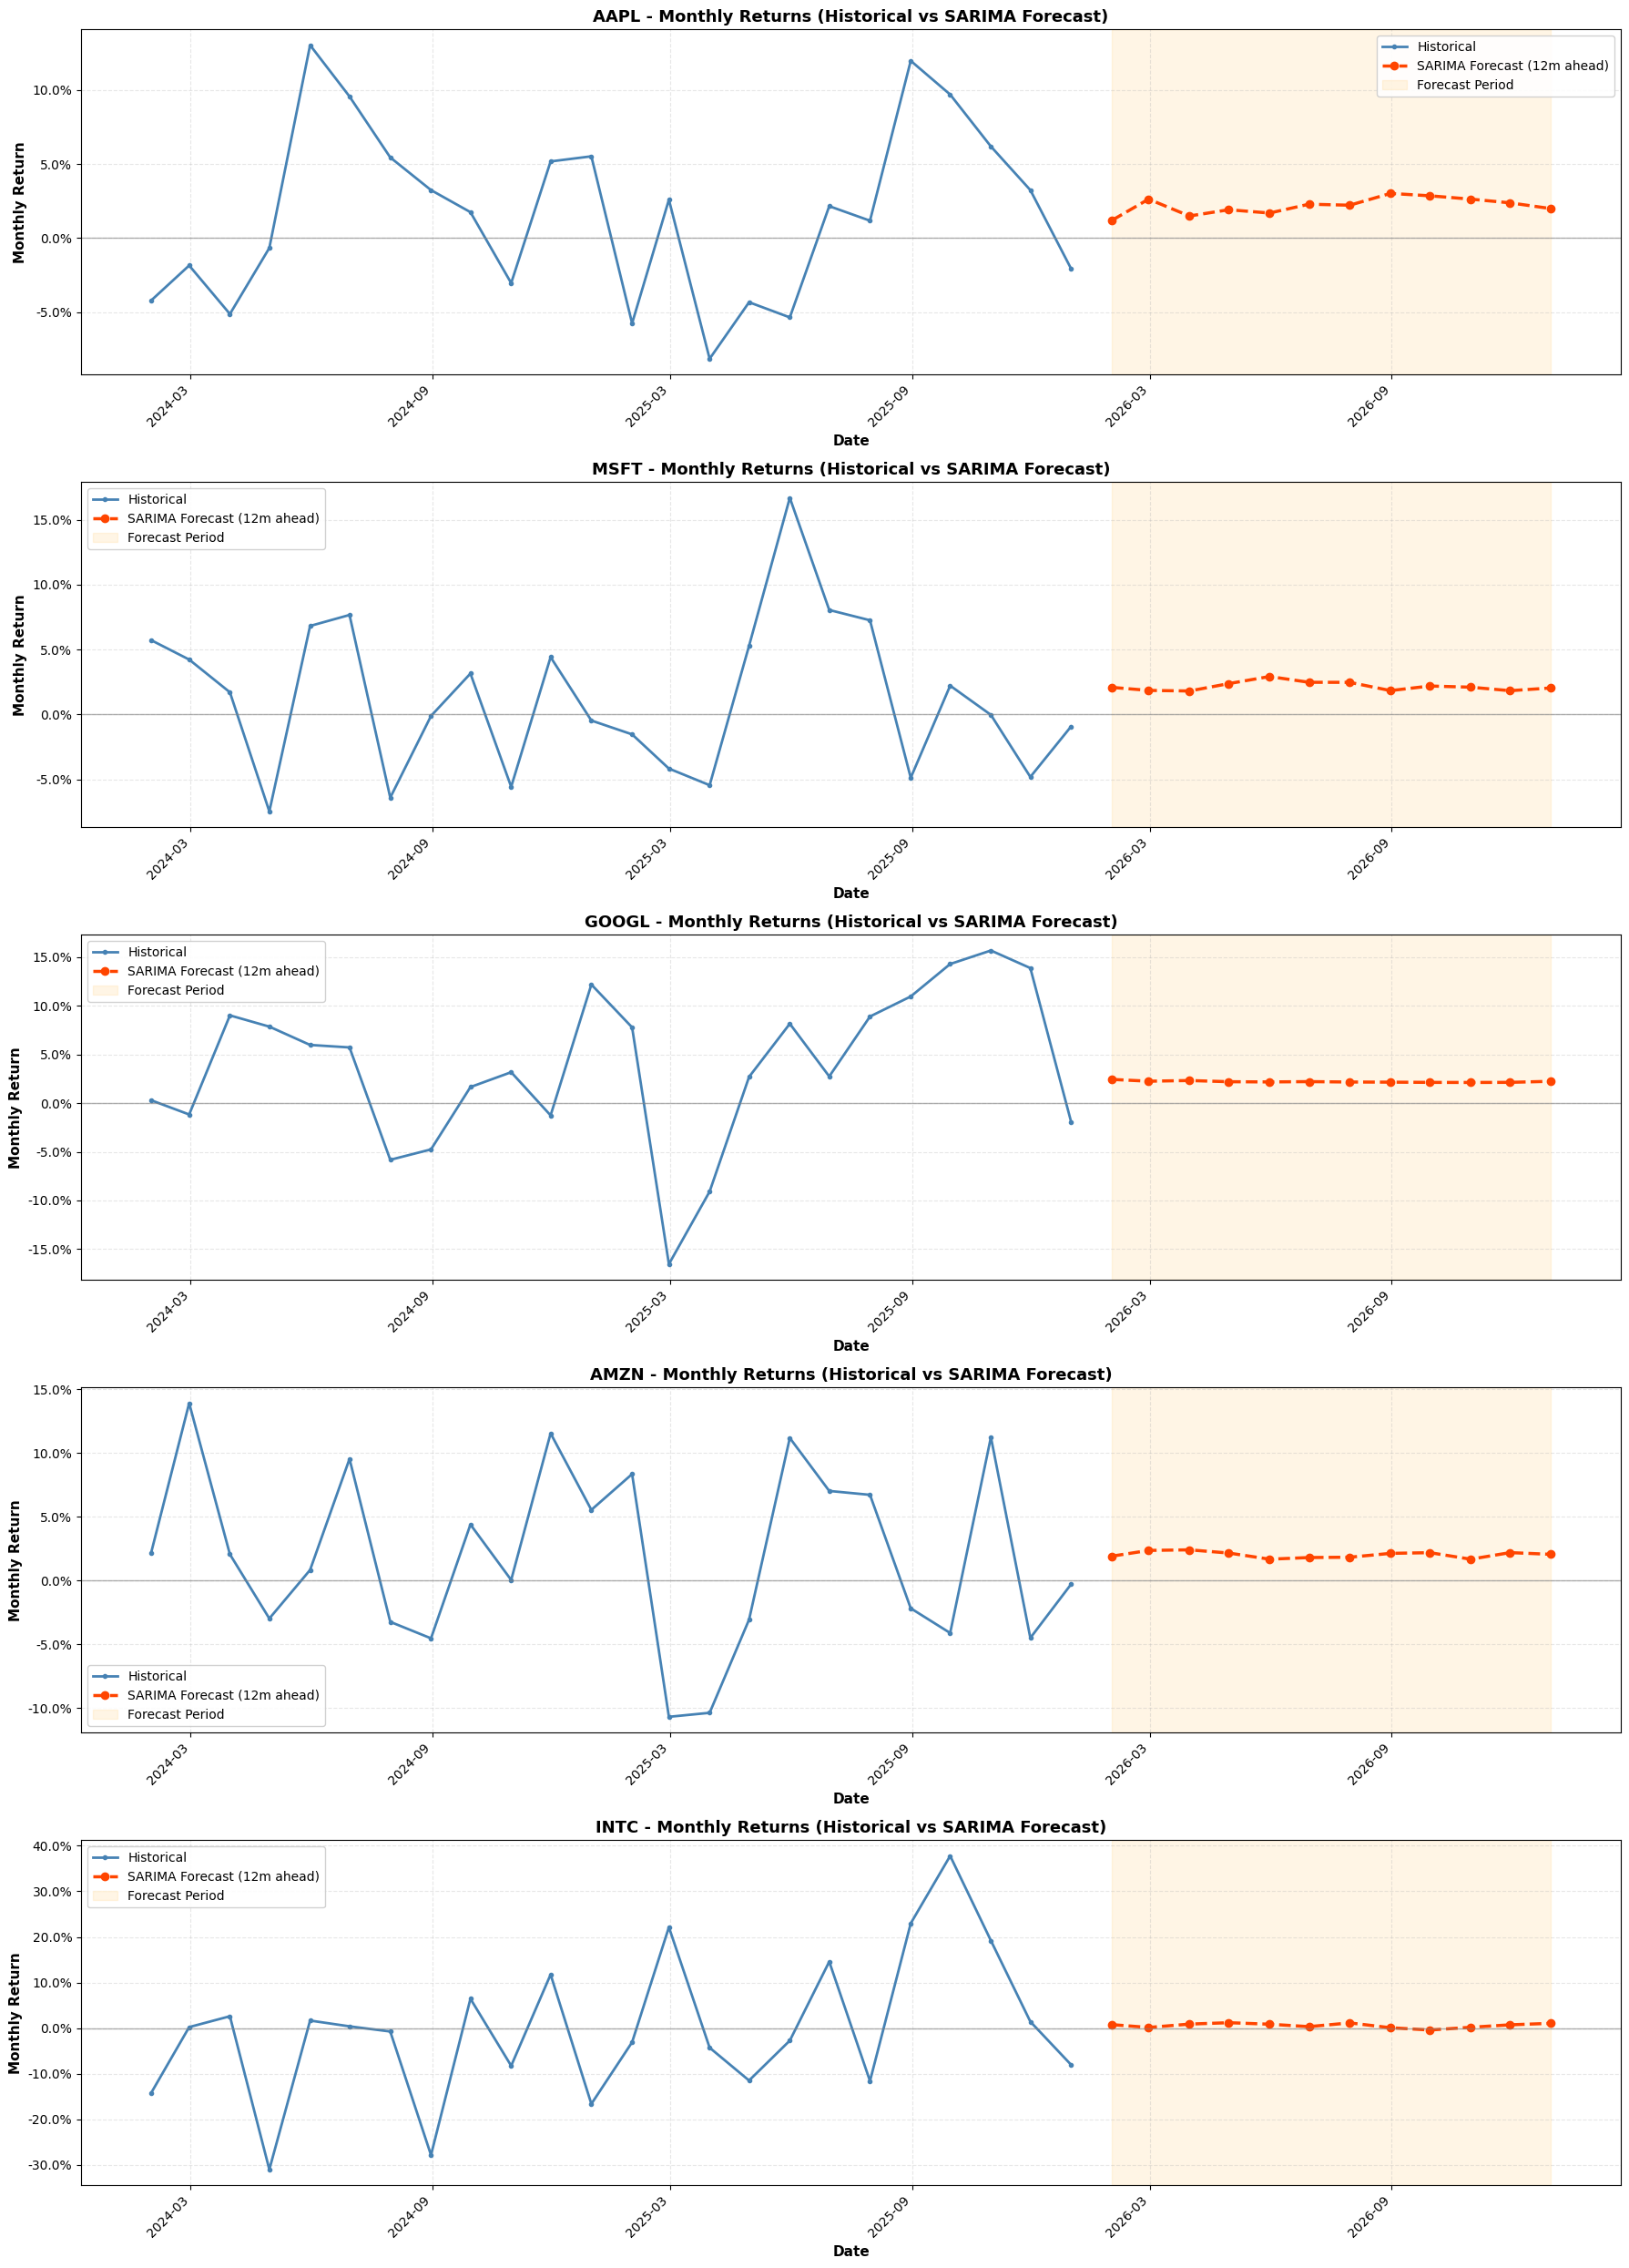


=== Summary Statistics: Historical vs Forecast ===


,Hist Mean (monthly),Hist Std (monthly),Forecast Mean (monthly),Forecast Std (monthly)
Ticker,,,,
AAPL,0.0245,0.0793,0.0219,0.0056
MSFT,0.0213,0.0591,0.0217,0.0034
GOOGL,0.0205,0.0722,0.0221,0.0009
AMZN,0.0211,0.0856,0.0202,0.0025
INTC,0.0088,0.1029,0.0058,0.0050


In [54]:
## 3.1) Visualización: Historical vs SARIMA Forecast por ticker

def plot_sarima_forecasts(ret_m, forecast_paths, tickers, n_hist_months=36):
    """
    Plot historical monthly returns vs SARIMA forecast for each ticker.
    One plot per ticker (vertical layout) for better X-axis visibility.
    
    Parameters:
    -----------
    ret_m : pd.DataFrame
        Monthly returns dataframe
    forecast_paths : dict
        Dictionary with ticker -> forecast Series
    tickers : list
        List of tickers to plot
    n_hist_months : int
        Number of historical months to display
    """
    n_tickers = len(tickers)
    
    # One column layout (vertical stacking)
    fig, axes = plt.subplots(n_tickers, 1, figsize=(18, 5 * n_tickers))
    
    # Handle single ticker case
    if n_tickers == 1:
        axes = [axes]
    
    for i, ticker in enumerate(tickers):
        ax = axes[i]
        
        # Historical data (last n_hist_months)
        hist = ret_m[ticker].dropna().tail(n_hist_months)
        
        # Forecast
        fc = forecast_paths.get(ticker, pd.Series())
        
        # Plot historical
        ax.plot(hist.index, hist.values, 
                label='Historical', color='steelblue', linewidth=2, marker='.')
        
        # Plot forecast
        if len(fc) > 0:
            ax.plot(fc.index, fc.values, 
                    label='SARIMA Forecast (12m ahead)', color='orangered', 
                    linewidth=2.5, linestyle='--', marker='o', markersize=6)
            
            # Add shaded area for forecast region
            ax.axvspan(fc.index[0], fc.index[-1], alpha=0.1, color='orange', 
                      label='Forecast Period')
        
        # Add zero line
        ax.axhline(y=0, color='gray', linestyle='-', linewidth=1, alpha=0.6)
        
        # Styling
        ax.set_title(f'{ticker} - Monthly Returns (Historical vs SARIMA Forecast)', 
                    fontweight='bold', fontsize=13)
        ax.set_xlabel('Date', fontweight='bold', fontsize=11)
        ax.set_ylabel('Monthly Return', fontweight='bold', fontsize=11)
        ax.legend(loc='best', fontsize=10, framealpha=0.9)
        ax.grid(True, alpha=0.3, linestyle='--')
        
        # Format y-axis as percentage
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.1%}'))
        
        # Improve X-axis date formatting
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))  # Every 6 months
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
        
    plt.tight_layout()
    plt.show()

# Generate plots
plot_sarima_forecasts(ret_m, forecast_paths, tickers, n_hist_months=24)  # Show last 24 months

# Optional: Summary statistics table
summary_stats = []
for ticker in tickers:
    hist_mean = ret_m[ticker].mean()
    hist_std = ret_m[ticker].std()
    fc = forecast_paths.get(ticker, pd.Series())
    fc_mean = fc.mean() if len(fc) > 0 else np.nan
    fc_std = fc.std() if len(fc) > 0 else np.nan
    
    summary_stats.append({
        'Ticker': ticker,
        'Hist Mean (monthly)': hist_mean,
        'Hist Std (monthly)': hist_std,
        'Forecast Mean (monthly)': fc_mean,
        'Forecast Std (monthly)': fc_std
    })

summary_df = pd.DataFrame(summary_stats).set_index('Ticker')
print("\n=== Summary Statistics: Historical vs Forecast ===")
display(summary_df.round(4))

## 4) Compute historical expected return (μ_hist) and blend (μ_final)

In [6]:
# Historical expected return for 1-year horizon from monthly returns
mu_hist = ((1 + ret_m[tickers].mean())**12 - 1)

# Blend for robustness
mu_final = (1 - alpha) * mu_hist + alpha * mu_arima.reindex(mu_hist.index)

pd.DataFrame({
    "mu_hist_1y": mu_hist,
    "mu_arima_1y": mu_arima,
    "mu_final_1y": mu_final
}).sort_values("mu_final_1y", ascending=False)


,mu_hist_1y,mu_arima_1y,mu_final_1y
AAPL,0.336827,0.296254,0.328712
MSFT,0.288095,0.293818,0.289240
AMZN,0.284900,0.271712,0.282262
GOOGL,0.276212,0.299481,0.280866
INTC,0.110703,0.071425,0.102848


## 5) Estimate annual covariance (Σ) from monthly returns

In [7]:
# Covariance estimated from portfolio tickers only
cov_m = ret_m[tickers].cov()
cov_ann = 12 * cov_m  # annualize

cov_ann.iloc[:5, :5]


Ticker,AAPL,MSFT,GOOGL,AMZN,INTC
Ticker,,,,,
AAPL,0.075400,0.032067,0.033153,0.042606,0.036313
MSFT,0.032067,0.041844,0.029864,0.038942,0.025537
GOOGL,0.033153,0.029864,0.062597,0.042564,0.027965
AMZN,0.042606,0.038942,0.042564,0.087925,0.023800
INTC,0.036313,0.025537,0.027965,0.023800,0.126985


## 6) MV Optimization: maximize Sharpe with rf under constraints

In [8]:
def portfolio_return(w, mu):
    return float(np.dot(w, mu))

def portfolio_vol(w, cov):
    return float(np.sqrt(np.dot(w, np.dot(cov, w))))

def neg_sharpe(w, mu, cov, rf):
    vol = portfolio_vol(w, cov)
    if vol <= 1e-12:
        return 1e6
    excess = portfolio_return(w, mu) - rf
    return -excess / vol

def solve_mvo_sharpe(mu, cov, rf=0.04, max_vol=0.225, wmin=0.01, wmax=0.25):
    tickers = mu.index.tolist()
    n = len(tickers)

    w0 = np.ones(n) / n
    w0 = np.clip(w0, wmin, wmax)
    w0 = w0 / w0.sum()

    bounds = [(wmin, wmax) for _ in range(n)]
    constraints = [
        {"type": "eq", "fun": lambda w: np.sum(w) - 1.0},
        {"type": "ineq", "fun": lambda w: max_vol - portfolio_vol(w, cov.values)}
    ]

    res = minimize(
        fun=lambda w: neg_sharpe(w, mu.values, cov.values, rf),
        x0=w0,
        method="SLSQP",
        bounds=bounds,
        constraints=constraints,
        options={"maxiter": 2000, "ftol": 1e-9, "disp": False}
    )
    if not res.success:
        raise RuntimeError(f"Optimization failed: {res.message}")

    return pd.Series(res.x, index=tickers), res

w_opt, opt_res = solve_mvo_sharpe(
    mu=mu_final,
    cov=cov_ann,
    rf=risk_free_rate,
    max_vol=max_volatility,
    wmin=min_weight,
    wmax=max_weight
)

w_opt.sort_values(ascending=False)


AAPL     0.25
GOOGL    0.25
MSFT     0.25
AMZN     0.24
INTC     0.01
dtype: float64

## 7) Report: recommended weights + portfolio metrics

In [9]:
ret_opt = portfolio_return(w_opt.values, mu_final.values)
vol_opt = portfolio_vol(w_opt.values, cov_ann.values)
sharpe_opt = (ret_opt - risk_free_rate) / vol_opt if vol_opt > 0 else np.nan

report = pd.DataFrame({
    "weight_recommended": w_opt,
    "mu_final_1y": mu_final,
    "mu_hist_1y": mu_hist,
    "mu_arima_1y": mu_arima
}).sort_values("weight_recommended", ascending=False)

print("=== Recommended Portfolio (MVP) ===")
print(f"Expected return (1y): {ret_opt:.2%}")
print(f"Expected vol (ann):   {vol_opt:.2%}   (max allowed {max_volatility:.2%})")
print(f"Sharpe (rf={risk_free_rate:.2%}): {sharpe_opt:.3f}")

report


=== Recommended Portfolio (MVP) ===
Expected return (1y): 29.35%
Expected vol (ann):   20.89%   (max allowed 22.50%)
Sharpe (rf=4.00%): 1.213


,weight_recommended,mu_final_1y,mu_hist_1y,mu_arima_1y
AAPL,0.25,0.328712,0.336827,0.296254
GOOGL,0.25,0.280866,0.276212,0.299481
MSFT,0.25,0.289240,0.288095,0.293818
AMZN,0.24,0.282262,0.284900,0.271712
INTC,0.01,0.102848,0.110703,0.071425


## 8) Compare performance over time: Original vs Recommended (static weights)
We compute the cumulative growth of $1 invested in each portfolio using **daily** prices and **static weights** (no rebalancing within the period).

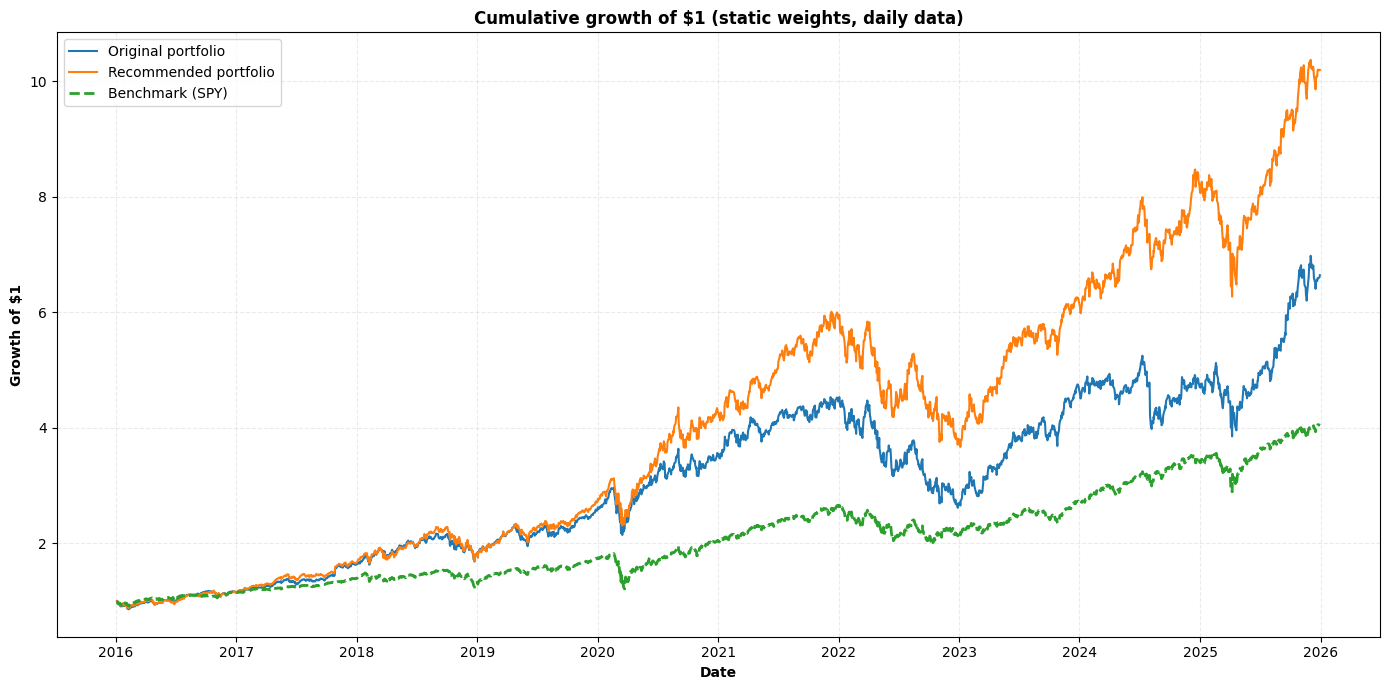

,final_growth_$1
Original,6.639083
Recommended,10.192269
Benchmark (SPY),4.032408


In [10]:
import matplotlib.pyplot as plt

def portfolio_cumulative_value(prices_daily, weights):
    # Align columns and weights
    w = weights.reindex(prices_daily.columns).fillna(0.0).astype(float)
    w = w / w.sum()
    # Daily returns
    r = prices_daily.pct_change().dropna()
    # Portfolio daily return
    pr = (r * w.values).sum(axis=1)
    # Growth of $1
    return (1 + pr).cumprod()

# Daily prices for portfolio tickers (drop benchmark if present)
prices_port_d = prices_d[tickers].dropna(how="all")

# Original and recommended weights (aligned & normalized)
w_current = current_weights.reindex(tickers).fillna(0.0)
w_current = w_current / w_current.sum()

w_reco = w_opt.reindex(tickers).fillna(0.0)
w_reco = w_reco / w_reco.sum()

cum_current = portfolio_cumulative_value(prices_port_d, w_current)
cum_reco = portfolio_cumulative_value(prices_port_d, w_reco)

# Optional benchmark series (growth of $1)
cum_bm = None
if benchmark is not None and benchmark in prices_d.columns:
    bm_prices = prices_d[[benchmark]].dropna()
    bm_ret = bm_prices.pct_change().dropna()
    cum_bm = (1 + bm_ret[benchmark]).cumprod()

plt.figure(figsize=(14, 7))
plt.plot(cum_current.index, cum_current.values, label="Original portfolio")
plt.plot(cum_reco.index, cum_reco.values, label="Recommended portfolio")
if cum_bm is not None:
    plt.plot(cum_bm.index, cum_bm.values, label=f"Benchmark ({benchmark})", linestyle="--", linewidth=2)

plt.title("Cumulative growth of $1 (static weights, daily data)", fontweight="bold")
plt.xlabel("Date", fontweight="bold")
plt.ylabel("Growth of $1", fontweight="bold")
plt.grid(True, alpha=0.25, linestyle="--")
plt.legend()
plt.tight_layout()
plt.show()

# Summary
final_table = pd.DataFrame({
    "final_growth_$1": {
        "Original": float(cum_current.iloc[-1]),
        "Recommended": float(cum_reco.iloc[-1]),
        **({f"Benchmark ({benchmark})": float(cum_bm.iloc[-1])} if cum_bm is not None else {})
    }
})
final_table


## 9) Optional: Compare against current weights (weights table)


In [11]:
# Current weights are computed from `portfolio` at the top.
cw = current_weights.reindex(w_opt.index).fillna(0.0).astype(float)
if cw.sum() > 0:
    cw = cw / cw.sum()

delta = w_opt - cw
comp = pd.DataFrame({
    "weight_current": cw,
    "weight_recommended": w_opt,
    "delta": delta
}).sort_values("delta", ascending=False)

comp


,weight_current,weight_recommended,delta
AAPL,0.132743,0.25,0.117257
GOOGL,0.159292,0.25,0.090708
MSFT,0.176991,0.25,0.073009
AMZN,0.265487,0.24,-0.025487
INTC,0.265487,0.01,-0.255487


## 10) Next iteration (beyond MVP)
- Covariance shrinkage (Ledoit–Wolf)
- Turnover control: penalty vs current weights
- Transaction costs/taxes
- Rolling backtest (yearly)
